In [202]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from glob import glob


In [203]:
! pip install torch_geometric==2.3.0

In [205]:
import numpy as np
import scipy.sparse as sp
import torch

def scipy_to_torch_sparse(scp_matrix):
    values = scp_matrix.data
    indices = np.vstack((scp_matrix.row, scp_matrix.col))
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = scp_matrix.shape

    sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))
    return sparse_tensor

## Adjacency Matrix
def mOrgan(N):
    sub = np.zeros([N, N])
    for i in range(0, N):
        sub[i, i-1] = 1
        sub[i, (i+1)%N] = 1
    return sub

## Downsampling Matrix
def mOrganD(N):
    N2 = int(np.ceil(N/2))
    sub = np.zeros([N2, N])
    
    for i in range(0, N2):
        if (2*i+1) == N:
            sub[i, 2*i] = 1
        else:
            sub[i, 2*i] = 1/2
            sub[i, 2*i+1] = 1/2
            
    return sub

def mOrganU(N):
    N2 = int(np.ceil(N/2))
    sub = np.zeros([N, N2])
    
    for i in range(0, N):
        if i % 2 == 0:
            sub[i, i//2] = 1
        else:
            sub[i, i//2] = 1/2
            sub[i, (i//2 + 1) % N2] = 1/2
            
    return sub

def genMatrixesLungsHeart():       
    RLUNG = 44
    LLUNG = 50
    HEART = 26
    
    Asub1 = mOrgan(RLUNG)
    Asub2 = mOrgan(LLUNG)
    Asub3 = mOrgan(HEART)
    
    ADsub1 = mOrgan(int(np.ceil(RLUNG / 2)))
    ADsub2 = mOrgan(int(np.ceil(LLUNG / 2)))
    ADsub3 = mOrgan(int(np.ceil(HEART / 2)))
                    
    Dsub1 = mOrganD(RLUNG)
    Dsub2 = mOrganD(LLUNG)
    Dsub3 = mOrganD(HEART)
    
    Usub1 = mOrganU(RLUNG)
    Usub2 = mOrganU(LLUNG)
    Usub3 = mOrganU(HEART)
        
    p1 = RLUNG
    p2 = p1 + LLUNG
    p3 = p2 + HEART
    
    p1_ = int(np.ceil(RLUNG / 2))
    p2_ = p1_ + int(np.ceil(LLUNG / 2))
    p3_ = p2_ + int(np.ceil(HEART / 2))
    
    A = np.zeros([p3, p3])
    
    A[:p1, :p1] = Asub1
    A[p1:p2, p1:p2] = Asub2
    A[p2:p3, p2:p3] = Asub3
    
    AD = np.zeros([p3_, p3_])
    
    AD[:p1_, :p1_] = ADsub1
    AD[p1_:p2_, p1_:p2_] = ADsub2
    AD[p2_:p3_, p2_:p3_] = ADsub3
   
    D = np.zeros([p3_, p3])
    
    D[:p1_, :p1] = Dsub1
    D[p1_:p2_, p1:p2] = Dsub2
    D[p2_:p3_, p2:p3] = Dsub3
    
    U = np.zeros([p3, p3_])
    
    U[:p1, :p1_] = Usub1
    U[p1:p2, p1_:p2_] = Usub2
    U[p2:p3, p2_:p3_] = Usub3
    
    return A, AD, D, U

In [206]:
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.cheb_conv import ChebConv
from torch_geometric.nn.inits import zeros, normal

# We change the default initialization from zeros to a normal distribution
class ChebConv(ChebConv):
    def reset_parameters(self):
        for lin in self.lins:
            normal(lin, mean = 0, std = 0.1)
            #lin.reset_parameters()
        normal(self.bias, mean = 0, std = 0.1)
        #zeros(self.bias)

# Pooling from COMA: https://github.com/pixelite1201/pytorch_coma/blob/master/layers.py
class Pool(MessagePassing):
    def __init__(self):
        # source_to_target is the default value for flow, but is specified here for explicitness
        super(Pool, self).__init__(flow='source_to_target')

    def forward(self, x, pool_mat,  dtype=None):
        pool_mat = pool_mat.transpose(0, 1)
        out = self.propagate(edge_index=pool_mat._indices(), x=x, norm=pool_mat._values(), size=pool_mat.size())
        return out

    def message(self, x_j, norm):
        return norm.view(1, -1, 1) * x_j
    
    
import torch.nn as nn
import torch.nn.functional as F

class residualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Args:
          in_channels (int):  Number of input channels.
          out_channels (int): Number of output channels.
          stride (int):       Controls the stride.
        """
        super(residualBlock, self).__init__()

        self.skip = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
          self.skip = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels, track_running_stats=False))
        else:
          self.skip = None

        self.block = nn.Sequential(nn.BatchNorm2d(in_channels, track_running_stats=False),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                   nn.BatchNorm2d(out_channels, track_running_stats=False),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(out_channels, out_channels, 3, padding=1)
                                   )   

    def forward(self, x):
        identity = x
        out = self.block(x)

        if self.skip is not None:
            identity = self.skip(x)

        out += identity
        out = F.relu(out)

        return out

In [207]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.ops.roi_align as roi_align

import numpy as np

class EncoderConv(nn.Module):
    def __init__(self, latents = 64, hw = 32):
        super(EncoderConv, self).__init__()
        
        self.latents = latents
        self.c = 4
        
        self.size = self.c * np.array([2,4,8,16,32], dtype = np.intc)
        
        self.maxpool = nn.MaxPool2d(2)
        
        self.dconv_down1 = residualBlock(1, self.size[0])
        self.dconv_down2 = residualBlock(self.size[0], self.size[1])
        self.dconv_down3 = residualBlock(self.size[1], self.size[2])
        self.dconv_down4 = residualBlock(self.size[2], self.size[3])
        self.dconv_down5 = residualBlock(self.size[3], self.size[4])
        self.dconv_down6 = residualBlock(self.size[4], self.size[4])
        
        self.fc_mu = nn.Linear(in_features=self.size[4]*hw*hw, out_features=self.latents)
        self.fc_logvar = nn.Linear(in_features=self.size[4]*hw*hw, out_features=self.latents)

    def forward(self, x):
        x = self.dconv_down1(x)
        x = self.maxpool(x)

        x = self.dconv_down2(x)
        x = self.maxpool(x)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)
        
        conv5 = self.dconv_down5(x)
        x = self.maxpool(conv5)
        
        conv6 = self.dconv_down6(x)
        
        x = conv6.view(conv6.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
                
        return x_mu, x_logvar, conv6, conv5


class SkipBlock(nn.Module):
    def __init__(self, in_filters, window):
        super(SkipBlock, self).__init__()
        
        self.window = window
        self.graphConv_pre = ChebConv(in_filters, 2, 1, bias = False) 
    
    def lookup(self, pos, layer, salida = (1,1)):
        B = pos.shape[0]
        N = pos.shape[1]
        F = layer.shape[1]
        h = layer.shape[-1]
        
        ## Scale from [0,1] to [0, h]
        pos = pos * h
        
        _x1 = (self.window[0] // 2) * 1.0
        _x2 = (self.window[0] // 2 + 1) * 1.0
        _y1 = (self.window[1] // 2) * 1.0
        _y2 = (self.window[1] // 2 + 1) * 1.0
        
        boxes = []
        for batch in range(0, B):
            x1 = pos[batch,:,0].reshape(-1, 1) - _x1
            x2 = pos[batch,:,0].reshape(-1, 1) + _x2
            y1 = pos[batch,:,1].reshape(-1, 1) - _y1
            y2 = pos[batch,:,1].reshape(-1, 1) + _y2
            
            aux = torch.cat([x1, y1, x2, y2], axis = 1)            
            boxes.append(aux)
                    
        skip = roi_align(layer, boxes, output_size = salida, aligned=True)
        vista = skip.view([B, N, -1])

        return vista
    
    def forward(self, x, adj, conv_layer):
        pos = self.graphConv_pre(x, adj)
        skip = self.lookup(pos, conv_layer)
        
        return torch.cat((x, skip, pos), axis = 2), pos
        
    
class Hybrid(nn.Module):
    def __init__(self, config, downsample_matrices, upsample_matrices, adjacency_matrices):
        super(Hybrid, self).__init__()
        
        self.config = config
        hw = config['inputsize'] // 32
        self.z = config['latents']
        self.encoder = EncoderConv(latents = self.z, hw = hw)
        
        self.downsample_matrices = downsample_matrices
        self.upsample_matrices = upsample_matrices
        self.adjacency_matrices = adjacency_matrices
        self.kld_weight = 1e-5
                
        n_nodes = config['n_nodes']
        self.filters = config['filters']
        self.K = 6
        self.window = (3,3)
        
        # Genero la capa fully connected del decoder
        outshape = self.filters[-1] * n_nodes[-1]          
        self.dec_lin = torch.nn.Linear(self.z, outshape)
                
        self.normalization2u = torch.nn.InstanceNorm1d(self.filters[1])
        self.normalization3u = torch.nn.InstanceNorm1d(self.filters[2])
        self.normalization4u = torch.nn.InstanceNorm1d(self.filters[3])
        self.normalization5u = torch.nn.InstanceNorm1d(self.filters[4])
        self.normalization6u = torch.nn.InstanceNorm1d(self.filters[5])
        
        outsize1 = self.encoder.size[4]
        outsize2 = self.encoder.size[4]  
                     
        # Guardo las capas de convoluciones en grafo
        self.graphConv_up6 = ChebConv(self.filters[6], self.filters[5], self.K)
        self.graphConv_up5 = ChebConv(self.filters[5], self.filters[4], self.K)       
        
        self.SC_1 = SkipBlock(self.filters[4], self.window)
        
        self.graphConv_up4 = ChebConv(self.filters[4] + outsize1 + 2, self.filters[3], self.K)        
        self.graphConv_up3 = ChebConv(self.filters[3], self.filters[2], self.K)
        
        self.SC_2 = SkipBlock(self.filters[2], self.window)
        
        self.graphConv_up2 = ChebConv(self.filters[2] + outsize2 + 2, self.filters[1], self.K)
        self.graphConv_up1 = ChebConv(self.filters[1], self.filters[0], 1, bias = False)
                
        self.pool = Pool()
        
        self.reset_parameters()
        
    def reset_parameters(self):
        torch.nn.init.normal_(self.dec_lin.weight, 0, 0.1)


    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) 
    
        
    def forward(self, x):
        self.mu, self.log_var, conv6, conv5 = self.encoder(x)

        if self.training:
            z = self.sampling(self.mu, self.log_var)
        else:
            z = self.mu
            
        x = self.dec_lin(z)
        x = F.relu(x)
        
        x = x.reshape(x.shape[0], -1, self.filters[-1])
        
        x = self.graphConv_up6(x, self.adjacency_matrices[5]._indices())
        x = self.normalization6u(x)
        x = F.relu(x)
        
        x = self.graphConv_up5(x, self.adjacency_matrices[4]._indices())
        x = self.normalization5u(x)
        x = F.relu(x)
        
        x, pos1 = self.SC_1(x, self.adjacency_matrices[3]._indices(), conv6)
        
        x = self.graphConv_up4(x, self.adjacency_matrices[3]._indices())
        x = self.normalization4u(x)
        x = F.relu(x)
        
        x = self.pool(x, self.upsample_matrices[0])
        
        x = self.graphConv_up3(x, self.adjacency_matrices[2]._indices())
        x = self.normalization3u(x)
        x = F.relu(x)
        
        x, pos2 = self.SC_2(x, self.adjacency_matrices[1]._indices(), conv5)
        
        x = self.graphConv_up2(x, self.adjacency_matrices[1]._indices())
        x = self.normalization2u(x)
        x = F.relu(x)
        
        x = self.graphConv_up1(x, self.adjacency_matrices[0]._indices()) # Sin relu y sin bias
        
        return x, pos1, pos2

In [208]:
import numpy as np
import cv2 
import torch
import scipy.sparse as sp

def loadModel(device):    
    A, AD, D, U = genMatrixesLungsHeart()
    N1 = A.shape[0]
    N2 = AD.shape[0]

    A = sp.csc_matrix(A).tocoo()
    AD = sp.csc_matrix(AD).tocoo()
    D = sp.csc_matrix(D).tocoo()
    U = sp.csc_matrix(U).tocoo()

    D_ = [D.copy()]
    U_ = [U.copy()]

    config = {}

    config['n_nodes'] = [N1, N1, N1, N2, N2, N2]
    A_ = [A.copy(), A.copy(), A.copy(), AD.copy(), AD.copy(), AD.copy()]
    
    A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A_, D_, U_))

    config['latents'] = 64
    config['inputsize'] = 1024

    f = 32
    config['filters'] = [2, f, f, f, f//2, f//2, f//2]
    config['skip_features'] = f

    hybrid = Hybrid(config.copy(), D_t, U_t, A_t).to(device)
    hybrid.load_state_dict(torch.load('/kaggle/input/chexmask-weights/SegmentationModel/bestMSE.pt', map_location=torch.device(device), weights_only=True))
    hybrid.eval()
    
    return hybrid



In [210]:
def preprocess(input_img):
    img = cv2.resize(input_img, (1024, 1024), interpolation=cv2.INTER_CUBIC)
    return img


def segment(input_img_path):
    hybrid = loadModel(device)
    
    input_img = cv2.imread(input_img_path, 0) / 255.0
    original_shape = input_img.shape[:2]
    
    img = preprocess(input_img)    
        
    data = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device).float()
    
    with torch.no_grad():
        output = hybrid(data)[0].cpu().numpy().reshape(-1, 2)
    
    output = output * original_shape[0]  # Scale back to original size
    output = output.astype('int')
    
    # Generate the overlapped image
    overlapped_image = drawOnTop(input_img, output)
    
    return output, overlapped_image

def getDenseMask(landmarks, h, w):
    RL = landmarks[0:44]
    LL = landmarks[44:94]
    H = landmarks[94:]
    
    img = np.zeros([h, w], dtype = 'uint8')
    
    RL = RL.reshape(-1, 1, 2).astype('int')
    LL = LL.reshape(-1, 1, 2).astype('int')
    H = H.reshape(-1, 1, 2).astype('int')

    img = cv2.drawContours(img, [RL], -1, 1, -1)
    img = cv2.drawContours(img, [LL], -1, 1, -1)
    img = cv2.drawContours(img, [H], -1, 2, -1)
    
    return img

def drawOnTop(img, landmarks):
    h, w = img.shape[:2]
    output = getDenseMask(landmarks, h, w)
    
    image = np.zeros([h, w, 3])
    image[:,:,0] = img + 0.3 * (output == 1).astype('float') - 0.1 * (output == 2).astype('float')
    image[:,:,1] = img + 0.3 * (output == 2).astype('float') - 0.1 * (output == 1).astype('float') 
    image[:,:,2] = img - 0.1 * (output == 1).astype('float') - 0.2 * (output == 2).astype('float') 

    image = np.clip(image, 0, 1)
    
    RL, LL, H = landmarks[0:44], landmarks[44:94], landmarks[94:]
    
    # Draw the landmarks as dots
    for l in RL:
        image = cv2.circle(image, (int(l[0]), int(l[1])), 5, (1, 0, 1), -1)
    for l in LL:
        image = cv2.circle(image, (int(l[0]), int(l[1])), 5, (1, 0, 1), -1)
    for l in H:
        image = cv2.circle(image, (int(l[0]), int(l[1])), 5, (1, 1, 0), -1)
    
    return image



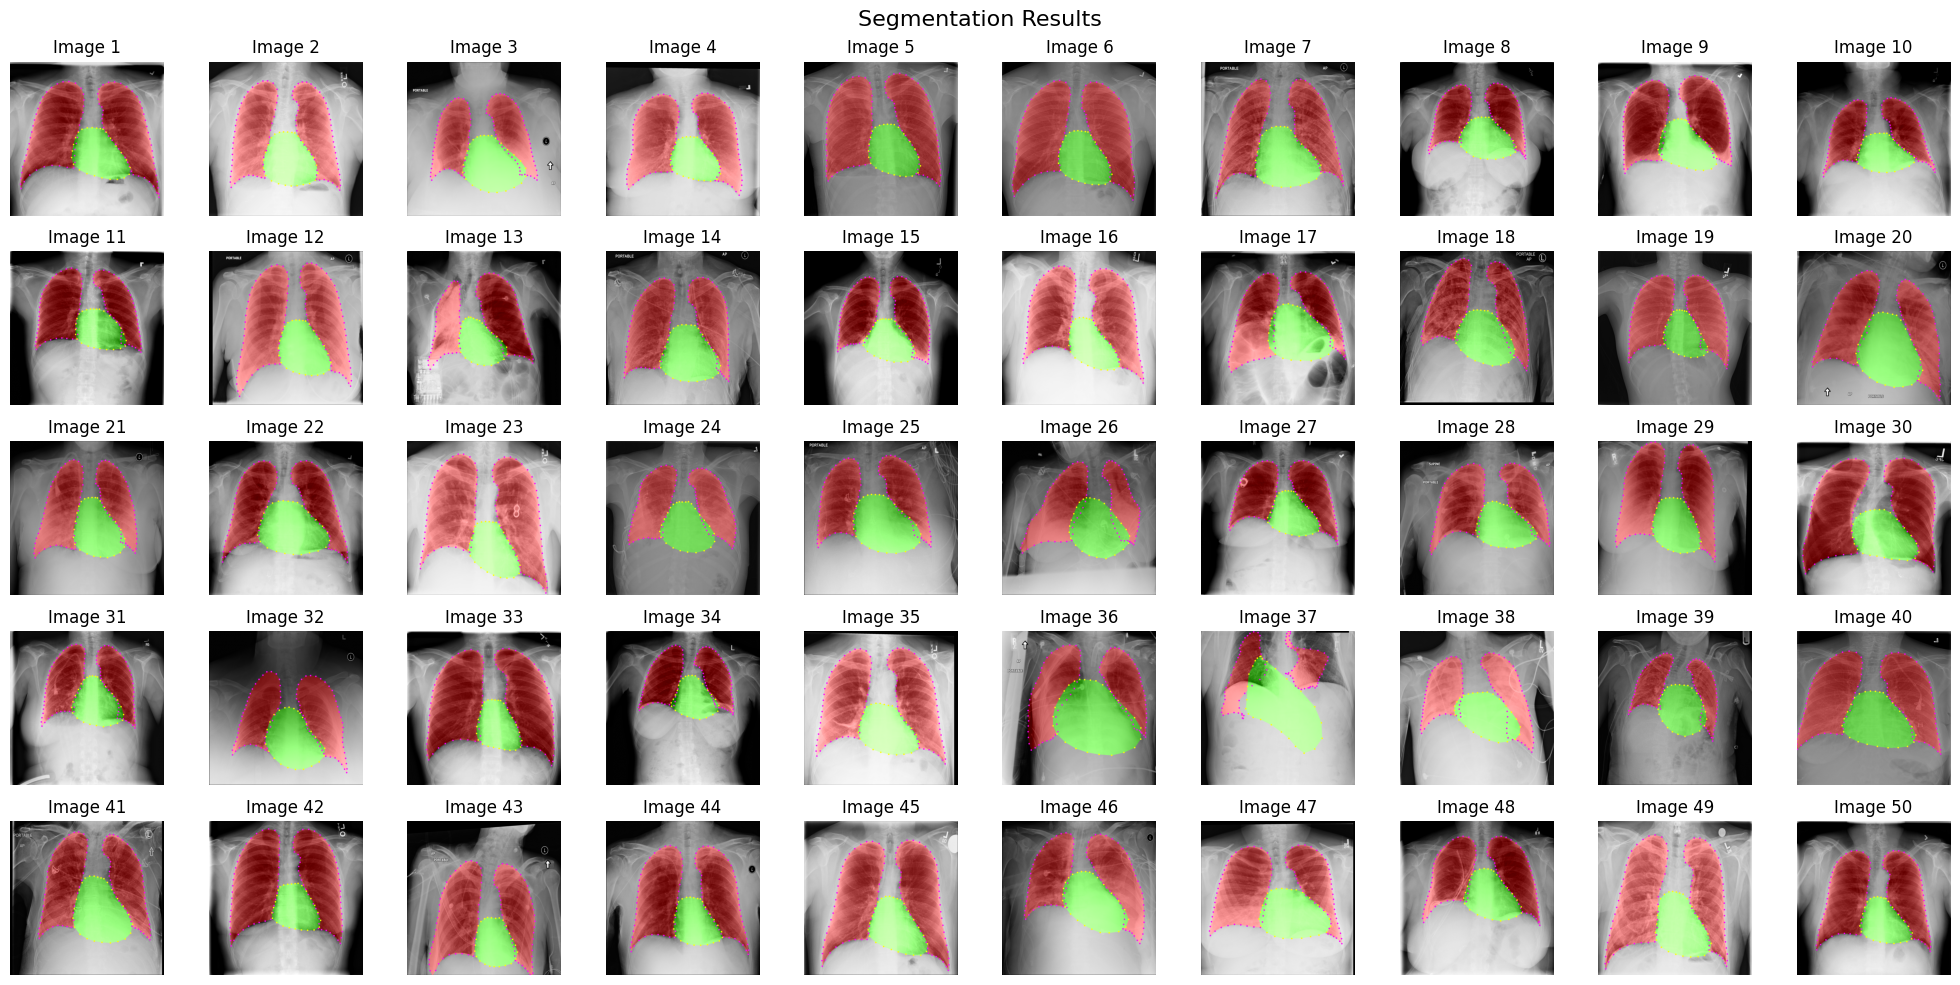

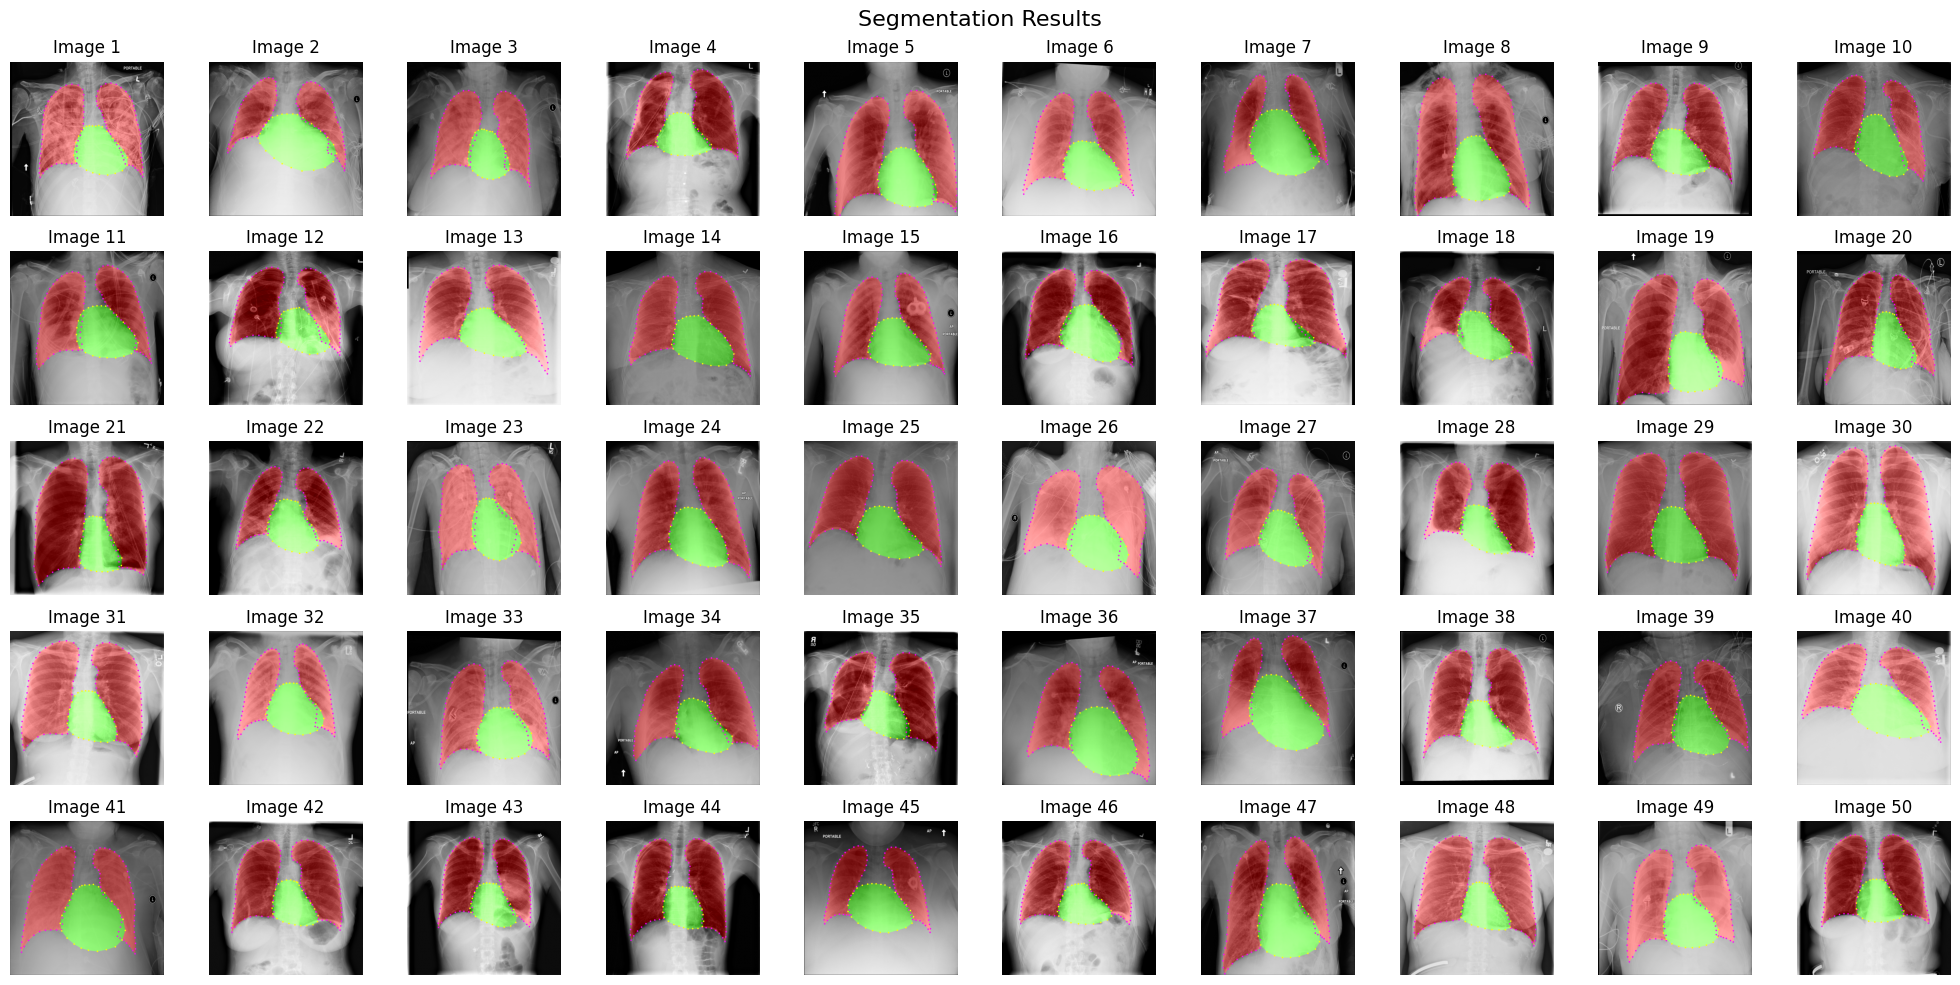

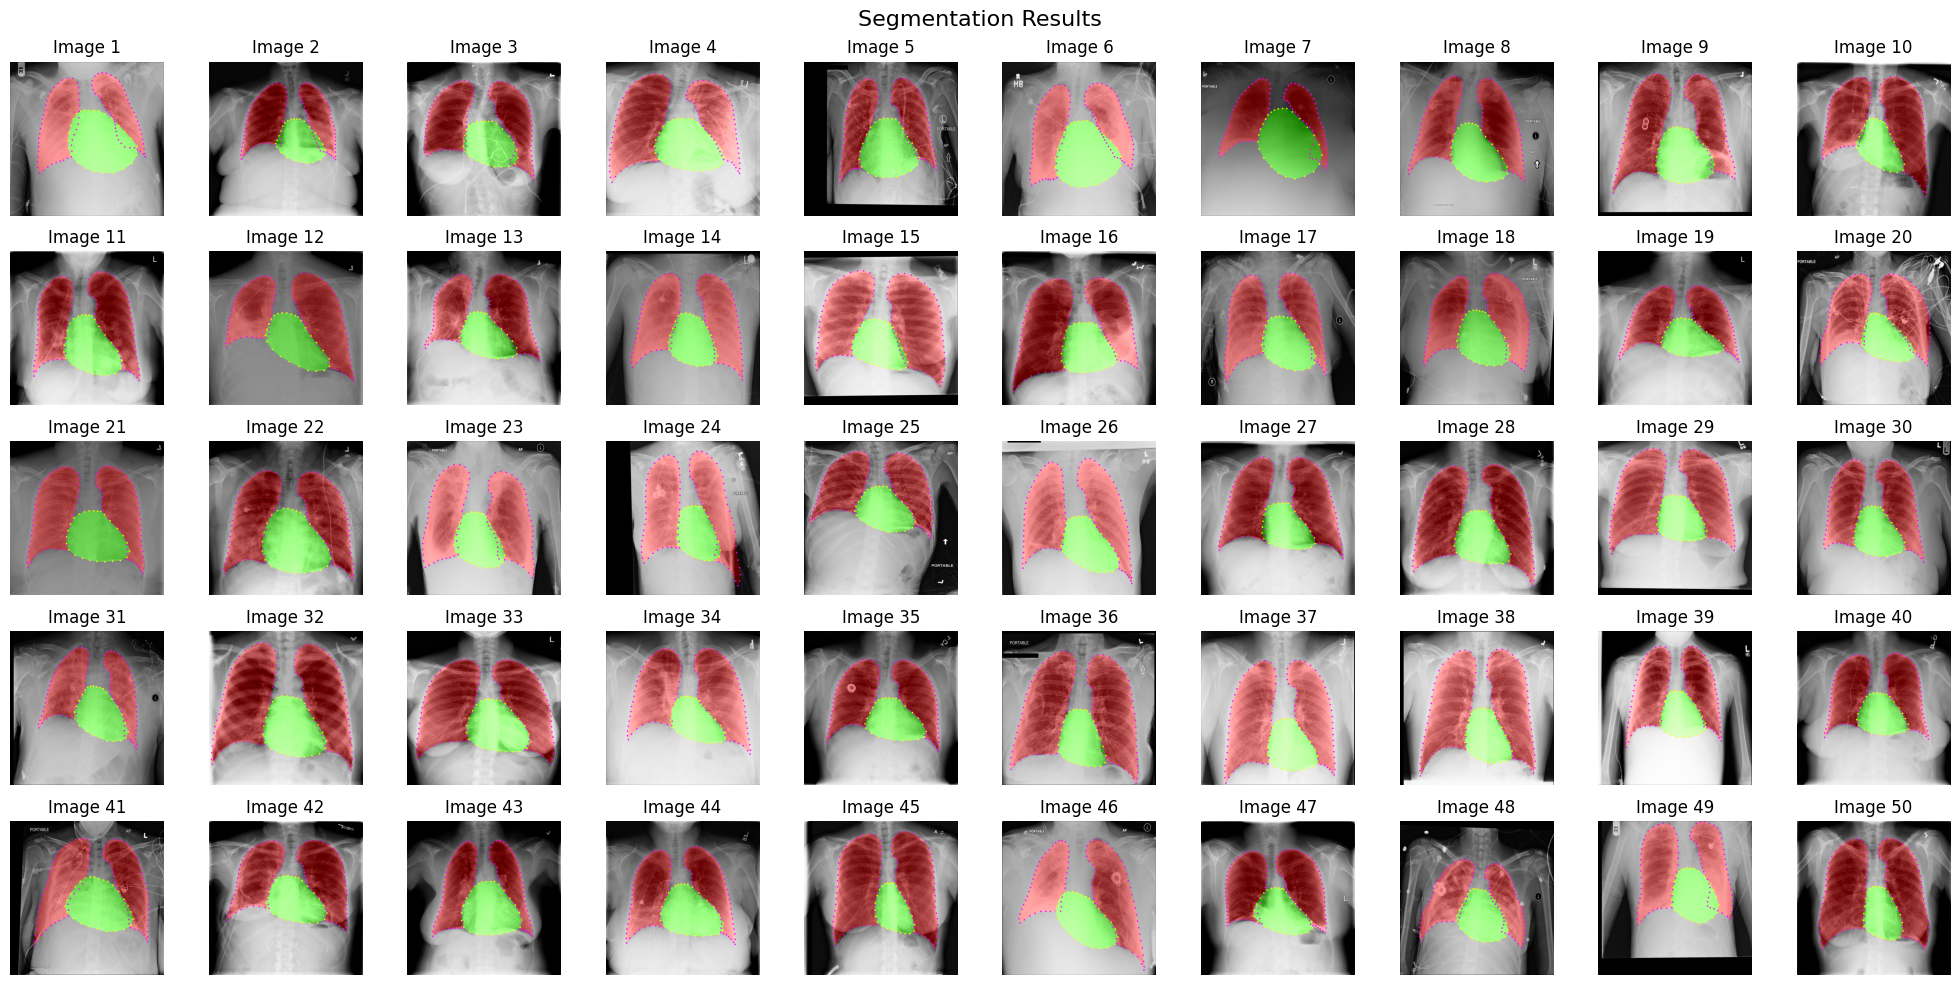

In [211]:
for i in range(3):
    # 이미지 파일 경로 가져오기
    image_paths = glob('/kaggle/input/cxr-nih-dataset/lung_diseases/*.png')[50*i:50*i+50]

    # 결과를 저장할 리스트
    results = []
    images = []

    # 각 이미지에 대해 segmentation 수행
    for img_path in image_paths:
        result, overlapped_image = segment(img_path)
        results.append(result)
        images.append(overlapped_image)

    # 결과 표시
    fig, axes = plt.subplots(5, 10, figsize=(20, 10))
    fig.suptitle('Segmentation Results', fontsize=16)

    for i, (ax, img) in enumerate(zip(axes.flatten(), images)):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Image {i+1}')

    plt.tight_layout()
    plt.show()

In [212]:
import cv2 
import matplotlib.pyplot as plt
def visualizeImg(imgage_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # 이미지 시각화
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')  
    plt.axis('off')  # 축 제거
    plt.show()  # 이미지 출력

In [213]:
image_path = "/kaggle/input/cxr-nih-dataset/lung_diseases/00000013_035.png"

In [216]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def crop_lung_mask(xray_image, lung_mask, direction='both'):
    # 마스크의 외곽선을 찾음
    contours, _ = cv2.findContours(lung_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 가장 큰 외곽선을 선택
    largest_contour = max(contours, key=cv2.contourArea)
    
    # 외곽선을 기준으로 bounding box 계산
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # 원본 X-ray 이미지와 마스크가 겹치는 부분만 남기기
    masked_xray_image = cv2.bitwise_and(xray_image, xray_image, mask=lung_mask)

    # 자를 방향에 따라 X-ray 이미지와 마스크를 동일한 방식으로 자름
    if direction == 'both':
        cropped_image = xray_image[y:y+h, x:x+w]
        cropped_mask = masked_xray_image[y:y+h, x:x+w]
    elif direction == 'width':
        cropped_image = xray_image[:, x:x+w]
        cropped_mask = masked_xray_image[:, x:x+w]
    elif direction == 'height':
        cropped_image = xray_image[y:y+h, :]
        cropped_mask = masked_xray_image[y:y+h, :]
    
    return cropped_image, cropped_mask



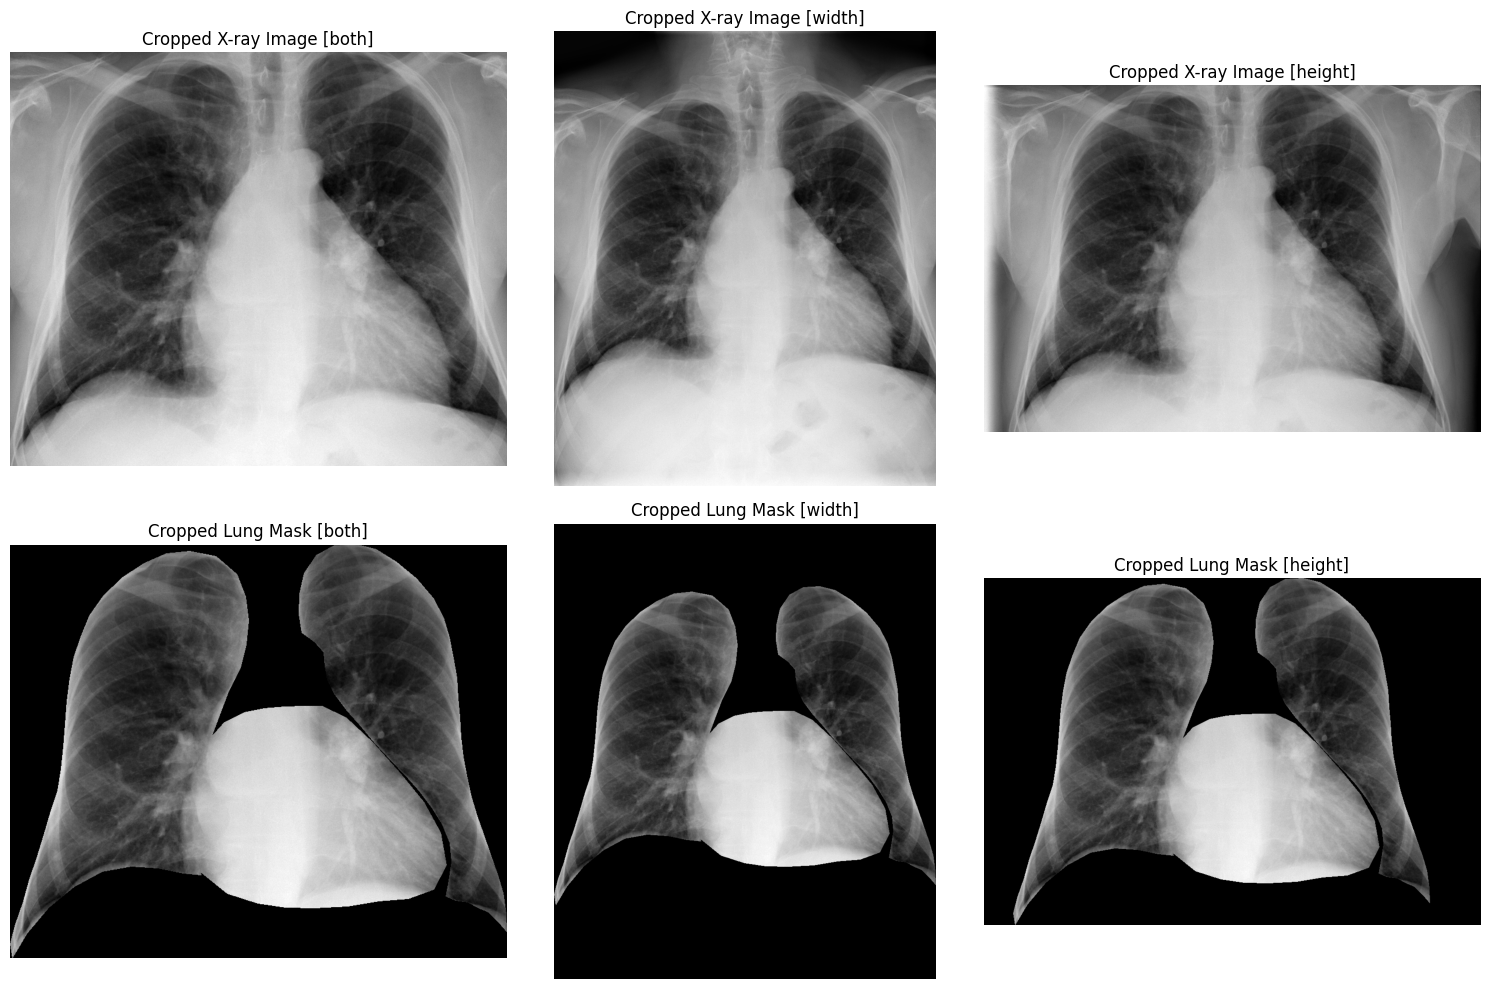

In [218]:
# X-ray 이미지 불러오기
image_path = "/kaggle/input/cxr-nih-dataset/lung_diseases/00000001_000.png"
xray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 폐 마스크 추출
landmarks, overlapped_image = segment(image_path)

# 폐 마스크 이미지 생성
lung_mask = getDenseMask(landmarks, xray_image.shape[0], xray_image.shape[1])

# 시각화
directions = ['both', 'width', 'height']
plt.figure(figsize=(15, 10))

for i in range(3):
    cropped_image, cropped_mask = crop_lung_mask(xray_image, lung_mask, direction=directions[i])
    
    # 윗줄에 크롭된 X-ray 이미지 (마스크와 겹치는 부분) 시각화
    plt.subplot(2, 3, i+1)
    plt.title(f"Cropped X-ray Image [{directions[i]}]")
    plt.imshow(cropped_image, cmap='gray')
    plt.axis('off')

    # 아랫줄에 크롭된 폐 마스크 이미지 시각화
    plt.subplot(2, 3, i+4)
    plt.title(f"Cropped Lung Mask [{directions[i]}]")
    plt.imshow(cropped_mask, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [231]:
import os
import cv2
import numpy as np
from tqdm import tqdm  # tqdm 라이브러리 임포트
import matplotlib.pyplot as plt

# 폐 마스크를 사용하여 X-ray 이미지를 크롭하는 함수 (기존 정의된 함수 사용)
def crop_lung_mask(xray_image, lung_mask, direction='both'):
    # 마스크의 외곽선을 찾음
    contours, _ = cv2.findContours(lung_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 가장 큰 외곽선을 선택
    largest_contour = max(contours, key=cv2.contourArea)
    
    # 외곽선을 기준으로 bounding box 계산
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # 원본 X-ray 이미지와 마스크가 겹치는 부분만 남기기
    masked_xray_image = cv2.bitwise_and(xray_image, xray_image, mask=lung_mask)

    # 자를 방향에 따라 X-ray 이미지와 마스크를 동일한 방식으로 자름
    if direction == 'both':
        cropped_image = xray_image[y:y+h, x:x+w]
        cropped_mask = masked_xray_image[y:y+h, x:x+w]
    elif direction == 'width':
        cropped_image = xray_image[:, x:x+w]
        cropped_mask = masked_xray_image[:, x:x+w]
    elif direction == 'height':
        cropped_image = xray_image[y:y+h, :]
        cropped_mask = masked_xray_image[y:y+h, :]
    
    return cropped_image, cropped_mask

# 크롭된 이미지를 저장하는 함수
def save_cropped_images(image, mask, base_name, direction, output_dir):
    # 파일 이름에서 확장자 제거하고 새로운 이름 생성
    file_name, ext = os.path.splitext(base_name)
    xray_filename = f"{file_name}_{direction}_cropped.png"
    mask_filename = f"{file_name}_{direction}_mask_cropped.png"

    # 이미지와 마스크 저장 경로 설정
    xray_save_path = os.path.join(output_dir, "cropped_xray_images", xray_filename)
    mask_save_path = os.path.join(output_dir, "cropped_masks", mask_filename)

    # 이미지를 저장할 디렉토리가 없으면 생성
    os.makedirs(os.path.dirname(xray_save_path), exist_ok=True)
    os.makedirs(os.path.dirname(mask_save_path), exist_ok=True)

    # 이미지와 마스크 저장
    cv2.imwrite(xray_save_path, image)
    cv2.imwrite(mask_save_path, mask)


input_dir = "/kaggle/input/cxr-nih-dataset/lung_diseases"
output_dir = "/kaggle/working/cropped_dataset"
os.makedirs(output_dir, exist_ok=True)
image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".png")]
for image_path in tqdm(image_paths, desc="Processing Images"):
    # 원본 이미지 파일 이름
    base_name = os.path.basename(image_path)
    xray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    landmarks, overlapped_image = segment(image_path)
    lung_mask = getDenseMask(landmarks, xray_image.shape[0], xray_image.shape[1])

    # 각 방향으로 이미지를 크롭하고 저장
    directions = ['both', 'width', 'height']
    for direction in directions:
        cropped_image, cropped_mask = crop_lung_mask(xray_image, lung_mask, direction=direction)
        save_cropped_images(cropped_image, cropped_mask, base_name, direction, output_dir)

Processing Images: 100%|██████████| 5000/5000 [38:17<00:00,  2.18it/s]
